# Read, munge, write

Data:

- [Lux regions](#Luc-Region)
- Download tabular data for Lux
- [GHSL for Lux](#GHSL---Population)
- [Night Lights](#Night-Lights)

---

In [1]:
%matplotlib inline

import os
import pandas
import rasterio
import rasterstats
import requests
import geopandas

from shapely.geometry import Polygon

## Lux Region

In [2]:
p = ("https://data.public.lu/en/datasets"
     "/r/83dca4aa-c873-42b6-9d4e-e98d9deeff81")
regions = geopandas.read_file(p)

# Other Lux Tabular Data

In [3]:
p = ("https://data.public.lu/en/datasets"\
     "/r/d92870e1-2f42-4940-9a9e-d34fe3caf8b2")
tst = geopandas.read_file(p)

In [4]:
j = geopandas.sjoin(tst, regions)\
             .groupby('LAU2___COD')\
             .size()

## GHSL - Population

- Download

In [5]:
url = ("http://cidportal.jrc.ec.europa.eu/ftp/"\
       "jrc-opendata/GHSL/GHS_POP_MT_GLOBE_R2019A/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250/V1-0/tiles/"\
       "GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0_18_3.zip")
s_path = url.split('/')[-1]
t_path = 'ghsl.tiff'

try:
    _ = open((f"src_data/{s_path.replace('.zip', '')}/"\
              f"{s_path.replace('.zip', '.tif')}")).close()
    print("File already stored locally")
except:
    print("Downloading...")
    r = requests.get(url)
    print("Writing...")
    fo = open(f"src_data/{s_path}", 'wb')
    fo.write(r.content)
    fo.close()
    print("Unzipping...")
    os.system(f"unzip -d src_data/{s_path.replace('.zip', '')} src_data/{s_path}")
    print("Done!")

File already stored locally


* Read

In [6]:
src = rasterio.open((f"src_data/{s_path.replace('.zip', '')}/"\
                     f"{s_path.replace('.zip', '')}.tif")
                    )

In [7]:
from rasterio.plot import show

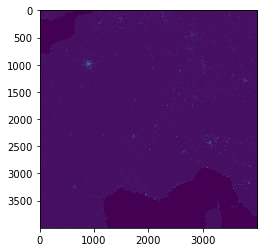

In [8]:
show(src.read());

* Clip

In [9]:
e, s, w, n = regions.to_crs(src.crs)\
                    .total_bounds
bbox = Polygon([(e, s),
                (w, s),
                (w, n),
                (e, n),
                (e, s)
               ])

In [10]:
from rasterio.mask import mask as riomask
out_image, out_transform = riomask(src, 
                                   [bbox],
                                   crop=True)
out_meta = src.meta.copy()

src.close()

* Write out

In [11]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(t_path, "w", **out_meta) as dest:
    dest.write(out_image)

* Test

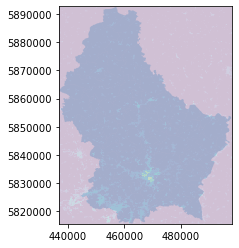

In [12]:
tst = rasterio.open('ghsl.tiff')

import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
show(tst, alpha=0.25, ax=ax)
regions.to_crs(tst.crs).plot(ax=ax, alpha=0.25);

* Aggregate to GHSL population to regions

In [13]:
ghsl = rasterio.open('ghsl.tiff')
rs = rasterstats.zonal_stats(regions.to_crs(ghsl.crs).geometry,
                             ghsl.read(1),
                             affine=ghsl.transform,
                             nodata=ghsl.nodata,
                             stats=['sum'])
rs = pandas.DataFrame(rs, index=regions.LAU2___COD)

## Night Lights

* Download

In [15]:
%%time

p = ('https://ngdc.noaa.gov/eog/data/'\
     'web_data/v4composites/F182013.v4.tar')
try:
    _ = open(f"src_data/nightlights/{p.split('/')[-1]}")
    print("File available locally")
except:
    print("Downloading...")
    r = requests.get(p)
    print("Writing...")
    with open(f"src_data/{p.split('/')[-1]}", 'wb') as fo:
        fo.write(r.content)

File available locally
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 25.3 ms


**NOTE**: next step (clipping to Lux extent only) was performed in QGIS using `F182013.v4c_web.stable_lights.avg_vis.tif.gz`

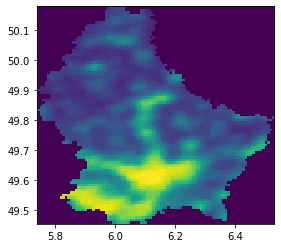

In [24]:
lights = rasterio.open('lights.tif')
show(lights);

* Aggregate by region

In [27]:
agg_lights = rasterstats.zonal_stats(regions.to_crs(lights.crs).geometry,
                                     lights.read(1),
                                     affine=lights.transform,
                                     nodata=lights.nodata,
                                     stats=['sum'])
agg_lights = pandas.DataFrame(agg_lights, index=regions.LAU2___COD)

/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


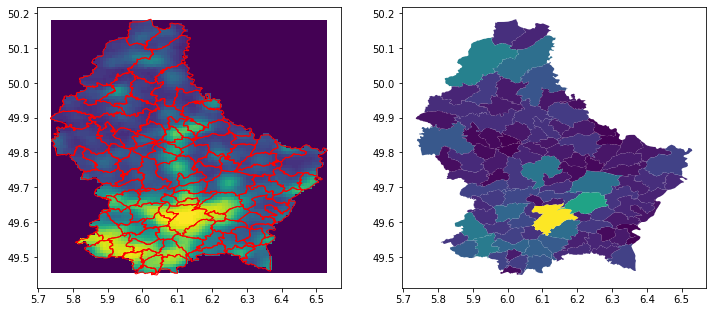

In [36]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
show(lights, ax=ax[0])
regions.plot(ax=ax[0], edgecolor='red', facecolor='none')
regions.set_index('LAU2___COD').assign(light_level=agg_lights).plot(column='light_level', ax=ax[1])

## Merge into table

In [37]:
db = regions.set_index("LAU2___COD")\
            .assign(tree_count=j)\
            .fillna(0)\
            .assign(ghsl_pop=rs)\
            .assign(light_level=agg_lights)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 102 entries, 0214 to 0608
Data columns (total 12 columns):
FID            102 non-null int64
POPULATION     102 non-null int64
COMMUNE_1      102 non-null object
LAU2           102 non-null object
_subtype       102 non-null object
COMMUNE        102 non-null object
DISTRICT       102 non-null object
CANTON         102 non-null object
geometry       102 non-null object
tree_count     102 non-null float64
ghsl_pop       102 non-null float64
light_level    102 non-null float64
dtypes: float64(3), int64(2), object(7)
memory usage: 10.4+ KB


In [38]:
db.to_file('lux_regions.gpkg', driver='GPKG')